In [1]:
import datatable as dt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# Problem: https://www.hackerearth.com/challenges/competitive/amexpert-code-lab/machine-learning/credit-card-default-risk-5-95cbc85f/
def clean_data(url, y=None, train=True):
    df = dt.fread(url).to_pandas()
    df.set_index('customer_id', inplace=True)
    df.drop(columns='name', inplace=True)
    # Replace weird values of a column by the most frequent ones
    df = df.replace({'gender': 'XNA'}, 'F').replace({'owns_car': ''}, 'N')
    if train:
        target_col = df.columns[-1]
        y = df[target_col]
        y = pd.Series(map(int, y), index=y.index)
        X = df.drop(columns=[target_col])
        return X, y
    else:
        return df

In [2]:
X_train, y_train = clean_data('train.csv', train=True)
X_test = clean_data('test.csv', train=False)

In [3]:
# Credit: https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """

    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                          "provide get_feature_names. "
                          "Will return input column names if available"
                          % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [f for f in column]

        return [f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))

    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names) == 0:
                _names = [f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle


# Credit: https://stackoverflow.com/questions/60273501/column-specific-processing-in-an-sklearn-pipeline
def process_data(X: pd.DataFrame, y=None, train=True):
    impute_transformer = Pipeline([('impute', IterativeImputer())])
    one_hot_transformer = Pipeline([('one_hot', OneHotEncoder(drop='first'))])
    scale_transformer = Pipeline([('standard_scale', StandardScaler())])

    null_cols = X.columns[X.isnull().any()]
    oh_cols, to_be_scaled_cols = [], []
    for col in X.columns:
        if np.issubdtype(X[col].dtype, np.number) and X[col].nunique() < 3:
            continue
        if not np.issubdtype(X[col].dtype, np.number):
            oh_cols.append(col)
        else:
            to_be_scaled_cols.append(col)

    if train:
        processor = ColumnTransformer([
            ('imputed', impute_transformer, null_cols),
            ('encoded', one_hot_transformer, oh_cols),
            ('scaled', scale_transformer, to_be_scaled_cols),
        ], remainder='passthrough')
        processor.fit(X)
        # Save to file in the current working directory
        with open('processor.pkl', 'wb') as file:
            pickle.dump(processor, file)
        X = pd.DataFrame(processor.transform(X), columns=get_feature_names(processor), index=y.index)
        return X, y
    else:
        # Load from file
        with open('processor.pkl', 'rb') as file:
            processor = pickle.load(file)
        X = pd.DataFrame(processor.transform(X), columns=get_feature_names(processor), index=X.index)
        return X

In [5]:
X_train, y_train = process_data(X_train, y_train, train=True)
X_test = process_data(X_test, train=False)

In [6]:
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv', header=False)
X_test.to_csv('X_test.csv')

In [7]:
X_train = dt.fread("X_train.csv").to_pandas().set_index(keys='customer_id', drop=True)
y_train = dt.fread("y_train.csv").to_pandas().iloc[:, 1]
y_train.index = X_train.index
X_test = dt.fread("X_test.csv").to_pandas().set_index(keys='customer_id', drop=True)

In [8]:
import optuna
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


# Credit: https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9
# Define an objective function to be maximized.
def objective(trial, X_train, y_train, cv, scoring):
    classifier = trial.suggest_categorical('classifier', ['lightgbm', 'catboost', 'xgboost'])
    model = LGBMClassifier()
    # Setup values for the hyperparameters:
    if classifier == 'lightgbm':
        params = {
            "num_leaves": trial.suggest_int('num_leaves', 45, 60),
            'min_child_samples': trial.suggest_uniform('min_child_samples', 100, 500),
            'min_child_weight': trial.suggest_int('min_child_weight', 30, 50, 5),
            'subsample': trial.suggest_uniform('subsample', 0.2, 0.8),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 0.6),
            'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]),
            'reg_lambda': trial.suggest_categorical('reg_lambda', [0, 1e-1, 1, 5, 10, 20, 50, 100]),
        }
        model = LGBMClassifier(**params)

    elif classifier == 'catboost':
        params = {
            "depth": trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_categorical('iterations', [250, 100, 500, 1000]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.03, 0.001, 0.01, 0.1, 0.2, 0.3]),
            'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', [3, 1, 5, 10, 100]),
            'border_count': trial.suggest_categorical('border_count', [32, 5, 10, 20, 50, 100, 200]),
            'bagging_temperature': trial.suggest_categorical('bagging_temperature', [0.03, 0.09, 0.25, 0.75]),
            'random_strength': trial.suggest_categorical('random_strength', [0.2, 0.5, 0.8]),
            'max_ctr_complexity': trial.suggest_categorical('max_ctr_complexity', [1, 2, 3, 4, 5])
        }
        model = CatBoostClassifier(**params)

    else:
        params = {
            "min_child_weight": trial.suggest_int('min_child_weight', 14, 20),
            'gamma': trial.suggest_int('gamma', 0, 5),
            "max_depth": trial.suggest_int('max_depth', 5, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            "colsample_bytree": trial.suggest_uniform('colsample_bytree', 0.1, 1.0),

        }
        model = XGBClassifier(**params)

    # Scoring method:
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=cv, scoring=scoring)
    return score.mean()

In [9]:
ss = StratifiedKFold(n_splits=5)

# Create study that minimizes
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train, cv=ss, scoring='f1_macro'),
               n_trials=100)

[I 2021-12-09 23:16:29,728] A new study created in memory with name: no-name-e077e0df-0e26-450a-9505-0bcaf64c58c9
[W 2021-12-09 23:16:34,705] Trial 0 failed, because the objective function returned nan.
[W 2021-12-09 23:16:35,112] Trial 1 failed, because the objective function returned nan.
[W 2021-12-09 23:16:54,509] Trial 2 failed, because the objective function returned nan.
[W 2021-12-09 23:16:55,035] Trial 3 failed, because the objective function returned nan.
[W 2021-12-09 23:16:55,464] Trial 4 failed, because the objective function returned nan.
[W 2021-12-09 23:17:00,444] Trial 5 failed, because the objective function returned nan.
[W 2021-12-09 23:17:11,973] Trial 6 failed, because the objective function returned nan.
[W 2021-12-09 23:17:14,725] Trial 7 failed, because the objective function returned nan.
[W 2021-12-09 23:17:19,319] Trial 8 failed, because the objective function returned nan.
[I 2021-12-09 23:17:27,664] Trial 9 finished with value: 0.921501882407442 and parame

In [10]:
print('Five best values')
pd.options.display.float_format = '{:,.2f}'.format
study.trials_dataframe().sort_values('value', ascending=True).head(5)

Five best values


,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_border_count,params_classifier,params_colsample_bytree,params_depth,...,params_max_ctr_complexity,params_max_depth,params_min_child_samples,params_min_child_weight,params_num_leaves,params_random_strength,params_reg_alpha,params_reg_lambda,params_subsample,state
10,10,0.92,2021-12-09 23:17:27.665201,2021-12-09 23:17:37.022554,0 days 00:00:09.357353,NaN,NaN,xgboost,0.57,NaN,...,NaN,7.00,NaN,19.00,NaN,NaN,NaN,NaN,0.97,COMPLETE
9,9,0.92,2021-12-09 23:17:19.320343,2021-12-09 23:17:27.663196,0 days 00:00:08.342853,NaN,NaN,xgboost,0.62,NaN,...,NaN,5.00,NaN,15.00,NaN,NaN,NaN,NaN,0.51,COMPLETE
30,30,0.92,2021-12-09 23:20:04.466760,2021-12-09 23:20:14.406157,0 days 00:00:09.939397,NaN,NaN,xgboost,0.43,NaN,...,NaN,8.00,NaN,18.00,NaN,NaN,NaN,NaN,0.86,COMPLETE
25,25,0.92,2021-12-09 23:19:40.595996,2021-12-09 23:19:50.111601,0 days 00:00:09.515605,NaN,NaN,xgboost,0.43,NaN,...,NaN,10.00,NaN,20.00,NaN,NaN,NaN,NaN,0.63,COMPLETE
17,17,0.92,2021-12-09 23:18:19.736725,2021-12-09 23:18:26.417593,0 days 00:00:06.680868,NaN,NaN,xgboost,0.39,NaN,...,NaN,6.00,NaN,20.00,NaN,NaN,NaN,NaN,0.69,COMPLETE


In [11]:
trial = study.best_trial
print(f'Loss : {trial}')
print(f"Best hyperparameters: {trial.params}")

Loss : FrozenTrial(number=16, values=[0.9237318161819783], datetime_start=datetime.datetime(2021, 12, 9, 23, 18, 15, 35271), datetime_complete=datetime.datetime(2021, 12, 9, 23, 18, 19, 735724), params={'classifier': 'xgboost', 'min_child_weight': 18, 'gamma': 0, 'max_depth': 8, 'subsample': 0.5993495781209559, 'colsample_bytree': 0.11631754891289292}, distributions={'classifier': CategoricalDistribution(choices=('lightgbm', 'catboost', 'xgboost')), 'min_child_weight': IntUniformDistribution(high=20, low=14, step=1), 'gamma': IntUniformDistribution(high=5, low=0, step=1), 'max_depth': IntUniformDistribution(high=10, low=5, step=1), 'subsample': UniformDistribution(high=1.0, low=0.5), 'colsample_bytree': UniformDistribution(high=1.0, low=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=16, state=TrialState.COMPLETE, value=None)
Best hyperparameters: {'classifier': 'xgboost', 'min_child_weight': 18, 'gamma': 0, 'max_depth': 8, 'subsample': 0.5993495781209559, 'cols

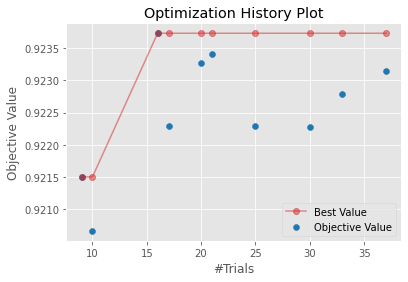

In [12]:
# plot the optimization history of the study
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study);

In [13]:
study.best_params

{'classifier': 'xgboost',
 'min_child_weight': 18,
 'gamma': 0,
 'max_depth': 8,
 'subsample': 0.5993495781209559,
 'colsample_bytree': 0.11631754891289292}

In [28]:
best_params = {key: value for key, value in study.best_params.items() if key != 'classifier'}
if study.best_params['classifier'] == 'lightgbm':
    best_model = LGBMClassifier(**best_params)
elif study.best_params['classifier'] == 'catboost':
    best_model = CatBoostClassifier(**best_params)
else:
    best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

[23:30:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.11631754891289292,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=18, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.5993495781209559, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [29]:
y_pred = best_model.predict(X_test)
y_pred = pd.DataFrame(data=y_pred, columns=['credit_card_default'])
y_pred.index = X_test.index
y_pred['credit_card_default'] = np.where(y_pred['credit_card_default'] == True, 1, 0)

In [30]:
y_pred.to_csv('Predicted value from Optuna.csv', index=True)